A multi-channel version of FEA-Net that solves the linear Laplace problem on a square place with a circle inside.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
def least_squares_loss(a, b):
    return F.mse_loss(a, b, reduction='sum')

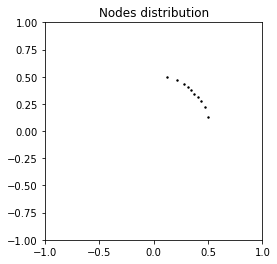

In [3]:
# Create a mesh for the square plate, containing a circle inside
mesh = MeshHandler(outfile="Results/plate_mesh.vtk")
plot.plot_pattern(mesh, key=4)

In [4]:
# Create multiple meshes
N = 2**8
L = int(np.log2(N))
for i in range(L):
    n = int(N/(2.**i))
    mesh = MeshHandler(nnode_edge = n+1, outfile="Results/plate_mesh-"+str(i)+".vtk")

In [4]:
def normal_distributed_tensor(size, dtype=torch.float32, requires_grad=False):
    return torch.tensor(np.random.normal(size=(size, size)).reshape((1, 1, size, size)),
                        dtype=dtype, requires_grad=requires_grad)

In [5]:
# Initialize Geometry and Boundary Conditions
size = 2 # The edge length of the square plate
nnode_edge = 65
n_iter = 20000 # Number of Jacobi iterations
plate = Geometry(nnode_edge)
f = torch.ones(1, 1, nnode_edge, nnode_edge) # Initialize forcing term
#initial_u = normal_distributed_tensor(nnode_edge)
initial_u = torch.zeros((1, 1, nnode_edge, nnode_edge), requires_grad=False)

In [6]:
# Instantiate the FEA-Net models
Knet = KNet(mesh) # Initialize the stiffness network, given mesh
fnet = FNet(size/(nnode_edge-1)) # Initialize the forcing term network, given mesh size
for param in Knet.parameters():
    param.requires_grad = False
for param in fnet.parameters():
    param.requires_grad = False

In [7]:
# Compute solution using Jacobi method
jac = JacobiBlock(Knet, fnet, mesh, 2/3., plate.geometry_idx, plate.boundary_value)
solution, error = jac.jacobi_convolution(initial_u, f, n_iter=n_iter)

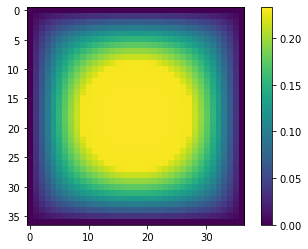

In [8]:
# plot the square domain of test solution 
solution_square = solution.view(nnode_edge, nnode_edge).numpy()
plot.plot_solution(solution_square,'Results/test_solution.png')

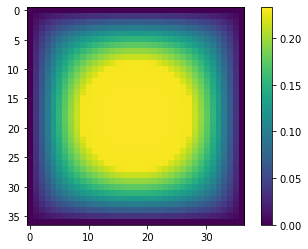

In [9]:
#  Use FEM solution as ground truth
data = sio.loadmat('Data/laplace_xy_matlab.mat')
solution_ground_truth = torch.from_numpy(data['u']).reshape(1,1,nnode_edge,nnode_edge)
error_matlab = data['error_arr']
plot.plot_solution(data['u'],'Results/ground_truth.png')

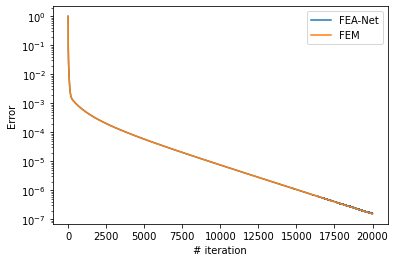

In [10]:
# Plot the iteration loss
plt.plot(error, label='FEA-Net')
plt.plot(error_matlab, label='FEM')
plt.yscale('log')
plt.xlabel('# iteration')
plt.ylabel('Error')
plt.legend()

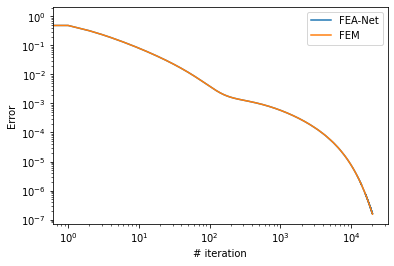

In [11]:
# Plot the iteration error
plt.loglog(error, label='FEA-Net')
plt.loglog(error_matlab, label='FEM')
plt.xlabel('# iteration')
plt.ylabel('Error')
plt.legend()
plt.savefig('Results/error.png')

In [12]:
# Save the solution to .vtk file
jac.mesh.mesh.point_data["u"] = solution.view(nnode_edge*nnode_edge).numpy()
jac.mesh.save_mesh('plate_solution.vtk')